# Learning agents for Specification MDPs #

In this notebook we explore the implementations of 2 learning agents in the specification MDP domain. The first is the regular Q-learning to generate optimal policy in the optimal paradigm. The second one is soft-Q-Learning that generates maximum entropy policies that can represent multimodal optimal policies.

As usual we begin by importing our sample MDP problem

In [12]:
from utils import *
from Exploration import *
from LearningAgents import *
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16,9]

MDP = CreateSampleMDP()

Now lets define a standard Q-learning agent. This agent has $\gamma = 0.95$ and an $\epsilon$-greedy exploration policy with $\epsilon = 0.2$. We will train this agent for a maximum of 10000 episodes and an upper limit of number of actions taken to be 100,000. Each episode is limited to 20 actions.

In [2]:
q_agent = QLearningAgent(MDP)
q_agent.Q_init = 0.01
q_agent.eps = 0.2
q_agent.explore(episode_limit = 10000, action_limit = 100000, verbose=True)
#q_agent.visualize_exploration(prog='twopi')


Training episode 9999         

(94261, 10000)

We can test how well this policy performed by initializing a second agent with the policy learned by the Q-learning agent.

[-1.0, -1.0, -0.94720000000000004, -0.77733333333333343, 1.0]

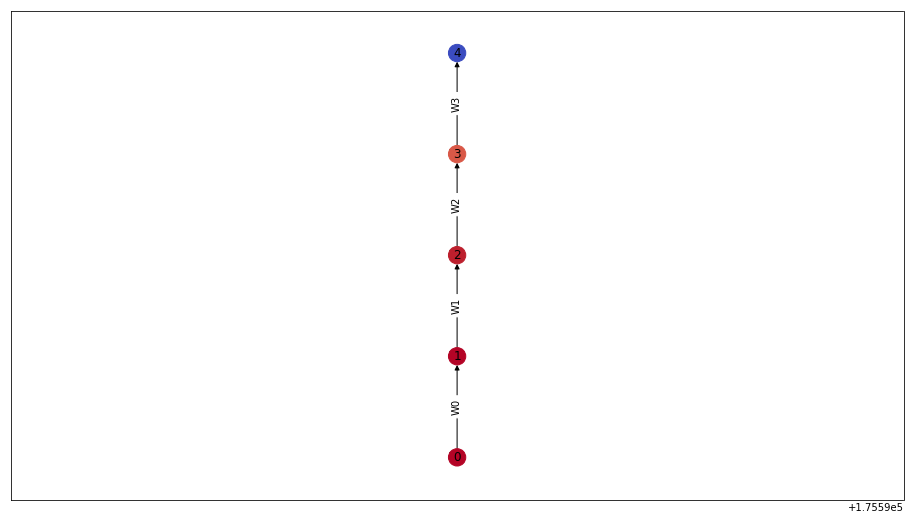

In [13]:
evaluator = ExplorerAgent(MDP, input_policy=q_agent.learned_policy)
evaluator.explore(episode_limit = 10)
evaluator.visualize_exploration(prog = 'twopi')

We can also visualize a distribution over the trajectories produced if a softmax policy with a very low temperature paramter was used to run at execution time. Here it is visualized over 1000 runs

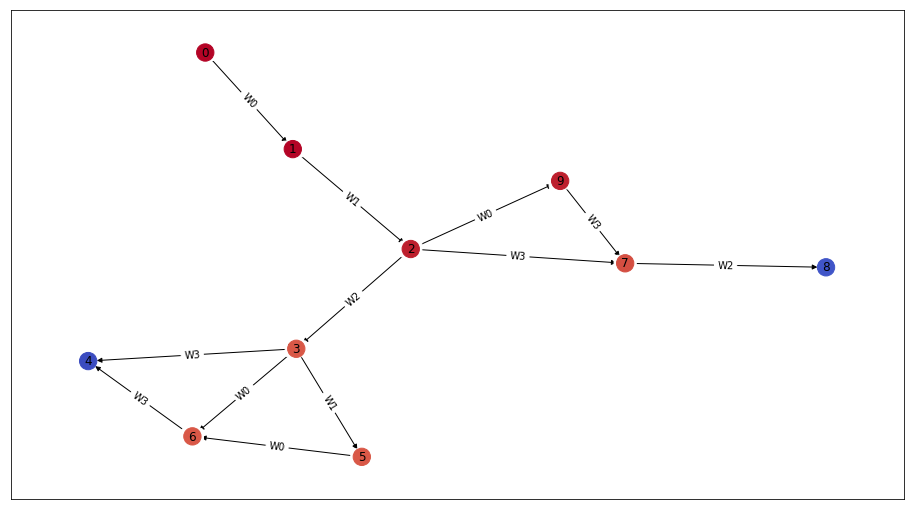

In [16]:
stochastic_evaluator = ExplorerAgent(MDP, input_policy = q_agent.create_learned_softmax_policy(temperature = 0.01))
stochastic_evaluator.explore(episode_limit = 1000)
_ = stochastic_evaluator.visualize_exploration(prog = 'neato')

We can also check what the final rewards for this are

In [15]:
rewards = [record[-1][3] for record in stochastic_evaluator.episodic_record]
print('Average terminal reward: ', np.mean(rewards))
print('Standard dev: ', np.std(rewards))

Average terminal reward:  0.998511333333
Standard dev:  0.00781676577052


Thus it looks like the softmax policy is accomplishing the assigned task to a very large extent when rolled out stochastically.

Now lets train a vanilla soft-q-learning agent

Training episode 5100         

[-1.0, -1.0]

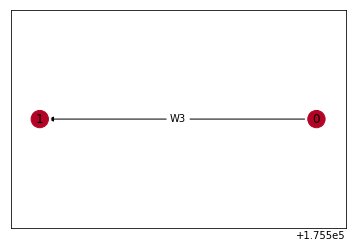

In [10]:
softmax_agent = QLearningAgent(MDP, soft_bellman=True)
softmax_agent.explore(episode_limit = 10000, action_limit = 100000, verbose = True)

evaluator = ExplorerAgent(MDP, input_policy=softmax_agent.learned_policy)
evaluator.explore(episode_limit = 10)
evaluator.visualize_exploration(prog = 'twopi')

This doesnt quite work. perhaps initializing the soft-Q-learning with the regular Q learning function might help?

In [12]:
softmax_agent = QLearningAgent(MDP, soft_bellman=True)
softmax_agent.Q_init = 0
softmax_agent.Q = q_agent.Q
softmax_agent.explore(episode_limit = 10000, action_limit = 100000, verbose = True)

Training episode 5000         

(100000, 5087)

[-1.0, -1.0, -1.0]

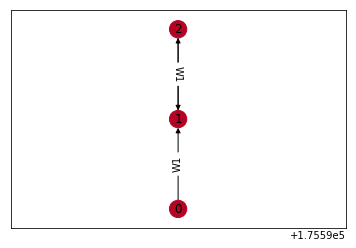

In [13]:
evaluator = ExplorerAgent(MDP, input_policy=softmax_agent.learned_softmax_policy)
evaluator.explore(episode_limit = 10)
evaluator.visualize_exploration(prog = 'twopi')

In [14]:
softmax_agent.MDP.initialize_state()
Qval = q_agent.get_max_Q_action(softmax_agent.MDP.state)[2]
softmax(Qval)

array([  2.41228558e-08,   1.46377006e-08,   5.17270776e-08,
         1.80791677e-08,   6.77881604e-09,   1.66358929e-09,
         9.99999725e-01,   1.54768701e-07,   2.72219444e-09])

So it looks like the standard implementation of soft-Q-learning is not working very well in this domain. I am not sure if it is due to implementation issues or hyperparameter tuning issues. The agent does not seem to be exploring very well is is very confident in a not so good action very early on.

## Counterfactual updates to specification states ##

Because the actions only result in changes to the physical world (ControlMDP). We can use counterfactual reasoning to update the Q values for all specification states. The intuition behind this is, imagine if I took an action from a given controlMDP state that resulted in another controlMDP state, but I was in a different specification state. To do that simply enable the `counterfactual_update` flag while initializing the learning agent.

In [17]:
cf_agent = QLearningAgent(MDP, counterfactual_updates=True, default_alpha=0.5)
cf_agent.explore(episode_limit = 200, action_limit = 200000, verbose = True)

Training episode 199         

(1870, 200)

Evaluating the deterministic policy learned by this automaton

[-1.0, -1.0, -0.94720000000000004, -0.77733333333333343, 1.0]

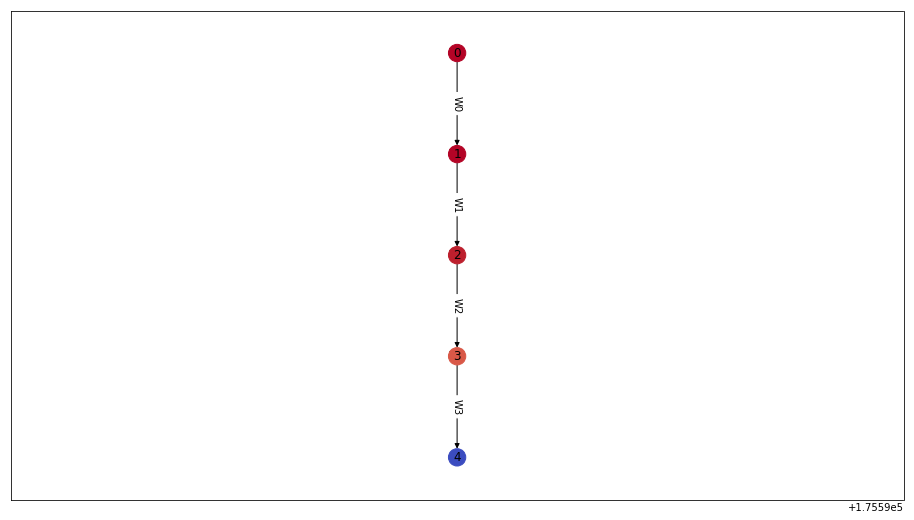

In [18]:
evaluator = ExplorerAgent(MDP, input_policy = cf_agent.learned_policy)
evaluator.explore(episode_limit = 10)
evaluator.visualize_exploration()

And in a stochastic setting

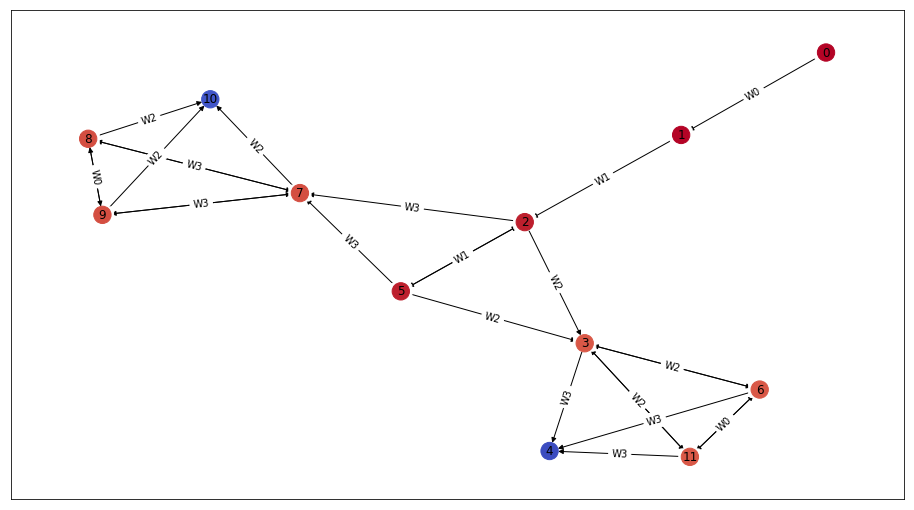

In [27]:
# stochastic_evaluator = ExplorerAgent(MDP, input_policy = cf_agent.create_learned_softmax_policy(0.02))
# stochastic_evaluator.explore(episode_limit = 500)
_ = stochastic_evaluator.visualize_exploration(prog = 'neato')

# Testing on a second domain: No temporal orderings #

In this domain there are no temporal orderings, so any ordering that performs all the tasks is acceptable.

In [26]:
MDP2 = CreateSpecMDP('ExampleSpecs2.json', 5, 5)

First we try out the Q-learning agent with the same hyperparameters as before

In [ ]:
q_agent2 = QLearningAgent(MDP2)
q_agent2.Q_init = 0.01
q_agent2.eps = 0.2
q_agent2.explore(episode_limit = 10000, action_limit = 100000, verbose=True)

Training episode 1923         

Evaluation of the deterministic optimal policy

In [ ]:
evaluator = ExplorerAgent(MDP, input_policy=q_agent2.learned_policy)
evaluator.explore(episode_limit = 10)
evaluator.visualize_exploration(prog = 'twopi')

Evaluation on the stochastic policy

In [ ]:
stochastic_evaluator = ExplorerAgent(MDP, input_policy = q_agent2.create_learned_softmax_policy(temperature = 0.01))
stochastic_evaluator.explore(episode_limit = 1000)
_ = stochastic_evaluator.visualize_exploration(prog = 'neato')

Now with the counterfactual updates

In [ ]:
cf_agent2 = QLearningAgent(MDP2, counterfactual_updates=True, default_alpha=0.5)
cf_agent2.explore(episode_limit = 200, action_limit = 200000, verbose = True)

In [ ]:
evaluator = ExplorerAgent(MDP, input_policy = cf_agent2.learned_policy)
evaluator.explore(episode_limit = 10)
evaluator.visualize_exploration()

In [ ]:
stochastic_evaluator = ExplorerAgent(MDP, input_policy = cf_agent2.create_learned_softmax_policy(0.02))
stochastic_evaluator.explore(episode_limit = 500)
_ = stochastic_evaluator.visualize_exploration(prog = 'neato')